# k-nearest neighbor (k-NN)

- nur notwendinge Features im Datensatz behalten
- Zielvariable extrahieren
- Aufteilen in Trainings- und Testdaten (80/20)

In [1]:
import geopandas as gpd
import pandas as pd

file_path = "../../data/processed_data/simra_osm_no_service_all.geojson"

gdf = gpd.read_file(file_path)

gdf.head(2)

,id,type,score,incidents,rides,index_right,maxspeed,asphalt,concrete,paving_stone,...,footway,highway_rare,living_street,path,primary,residential,secondary,tertiary,track,geometry
0,[100049].0,Street,0.0,0,138,35281.0,50,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.75,0.0,0.0,"POLYGON ((13.45412 52.54035, 13.45320 52.53977..."
1,[100069498].0,Junction,0.0,0,200,44754.0,30,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.00,0.0,0.0,"POLYGON ((13.52273 52.50704, 13.52248 52.50690..."


In [2]:
gdf.columns

Index(['id', 'type', 'score', 'incidents', 'rides', 'index_right', 'maxspeed',
       'asphalt', 'concrete', 'paving_stone', 'sett', 'unpaved', 'markers',
       'highway', 'cycleway', 'footway', 'highway_rare', 'living_street',
       'path', 'primary', 'residential', 'secondary', 'tertiary', 'track',
       'geometry'],
      dtype='object')

#### Entfernen nicht benötigter Spalten (Columns)

In [4]:
df = gdf.drop(columns=['id', 'index_right', 'geometry', 'markers', 'highway', 'incidents', 'rides', 'type'])

df.head()

,score,maxspeed,asphalt,concrete,paving_stone,sett,unpaved,cycleway,footway,highway_rare,living_street,path,primary,residential,secondary,tertiary,track
0,0.0,50,0.000000,1.0,0.0,0.0,0.000000,0.250000,0.0,0.0,0.0,0.0,0.0,0.000000,0.750000,0.000000,0.0
1,0.0,30,1.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0
2,0.0,50,0.846154,0.0,0.0,0.0,0.153846,0.384615,0.0,0.0,0.0,0.0,0.0,0.153846,0.461538,0.000000,0.0
3,0.0,30,0.500000,0.0,0.0,0.0,0.500000,0.000000,0.0,0.0,0.0,0.0,0.0,1.000000,0.000000,0.000000,0.0
4,0.0,50,1.000000,0.0,0.0,0.0,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.666667,0.0


#### Features und Label auswählen - Zielvariable festlegen

In [5]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error

# Zielvariable 
y = df['score']

# Alle anderen Spalten als Features verwenden 
X = df.drop(columns=['score'])

#### Aufteilen der Daten in Trainings- und Testdaten (80/20) - Ausgabe der Verteilung

In [6]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Anzahl der Trainingsdaten: {X_train.shape[0]}")
print(f"Anzahl der Testdaten: {X_test.shape[0]}")


Anzahl der Trainingsdaten: 12434
Anzahl der Testdaten: 3109


#### Preprocessing: numerische Variablen skalieren

#### Min-Max-Scaler

In [7]:
from sklearn.preprocessing import MinMaxScaler

preprocessor_mms = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), ['maxspeed', 'asphalt', 'concrete', 
                                 'paving_stone', 'sett', 'unpaved', 
                                 'cycleway', 'footway', 'highway_rare', 
                                 'living_street', 'path', 'primary', 
                                 'residential', 'secondary', 
                                 'tertiary', 'track'])
    ])

#### k-NN Modell und Pipeline erstellen - (preprocessor_mms - Min-Max-Scaler)

In [8]:
pipeline = Pipeline(steps=[('preprocessor', preprocessor_mms),
                           ('knn', KNeighborsRegressor(n_neighbors=5))])

#### Modell trainieren

In [9]:
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['maxspeed', 'asphalt',
                                                   'concrete', 'paving_stone',
                                                   'sett', 'unpaved',
                                                   'cycleway', 'footway',
                                                   'highway_rare',
                                                   'living_street', 'path',
                                                   'primary', 'residential',
                                                   'secondary', 'tertiary',
                                                   'track'])])),
                ('knn', KNeighborsRegressor())])

- **Pipeline und Preprocessing:**
Das Preprocessing in einer Pipeline ist sinnvoll, da es sicherstellt, dass dieselben Transformationen auf Trainings- und Testdaten angewendet werden.

Das Training ohne Pipeline ist möglich, aber fehleranfälliger und weniger flexibel.
Die Pipeline *erleichtert die Anwendung von Transformationen* und *verbessert die Lesbarkeit und Wiederverwendbarkeit des Codes*.

- **Min-Max_Scaler:**
    - Methoden zur Normalisierung von Daten
    - skaliert die Daten auf einen definierten Bereich, typischerweise [0, 1], indem er die Minimal- und Maximalwerte der Daten verwendet. Dadurch werden alle Features proportional auf die gleiche Skala gebracht.

Min-Max-Scaler ist sinnvoll, wenn die Daten bereits in einem natürlichen Bereich liegen oder wenn die Features keine Normalverteilung aufweisen, aber dennoch gleich gewichtet werden sollen.

#### Vorhersagen treffen

In [10]:
y_pred = pipeline.predict(X_test)

#### Modell evaluieren

In [11]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

Mean Squared Error: 0.0019
R² Score: -0.1425
Mean Absolute Error: 0.0152




### Mean Squared Error

- Der **Mean Squared Error (MSE)** ist eine Maßzahl, die die durchschnittliche quadratische Abweichung der vorhergesagten Werte von den tatsächlichen Werten im Modell angibt.

- Ein niedriger Wert, wie **0.0019**, deutet darauf hin, dass dein Modell in der Lage ist, die tatsächlichen Werte relativ genau vorherzusagen. Das bedeutet, dass die Vorhersagen des Modells nahe bei den tatsächlichen Werten liegen.
- Dennoch ist es wichtig, diesen Wert im Kontext eines spezifischen Anwendungsfalls und der Skala des Zielwerts zu betrachten.

### R²

Ein negativer R²-Score ist ein starkes Signal dafür, dass das Modell nicht gut funktioniert. Es erfordert eine genauere Untersuchung der Daten, des Modells und der gewählten Features, um herauszufinden, warum das Modell die Varianz der Zielvariable nicht adäquat erklären kann.

Ein R²-Score von -0.1425 ist ein ungewöhnliches Ergebnis. 

#### Interpretation des R²-Scores:

- **R²-Wert** (auch als Bestimmtheitsmaß bekannt) misst, wie gut das Modell die Varianz der Zielvariablen erklärt. Ein R²-Wert von **1.0** bedeutet, dass das Modell alle Variationen perfekt erklärt, während ein R²-Wert von **0.0** bedeutet, dass das Modell überhaupt keine Erklärungskraft hat.
  
- **Negativer R²-Wert:** Wenn der R²-Wert negativ ist, bedeutet das, dass das *Modell schlechter abschneidet* als ein einfaches Mittelwertsmodell (das heißt, ein Modell, das immer nur den Durchschnittswert der Zielvariablen vorhersagt).

#### Warum kann der R²-Wert negativ sein?
- **Schlechtes Modell:** Das Modell könnte schlecht sein, weil es nicht in der Lage ist, die Muster in den Daten zu erfassen.

- **Überanpassung/Underfitting:** Das Modell könnte zu stark an das Rauschen der Trainingsdaten angepasst sein (Overfitting) oder es erfasst die grundlegenden Zusammenhänge nicht gut genug (Underfitting).

- **Falsche Feature-Auswahl:** Es kann sein, dass die ausgewählten Features nicht aussagekräftig sind oder wichtige Features fehlen.

#### Was kann man tun? Was könnten weitere Schritte sein?

- **Daten und Modell prüfen:** Überprüfung der Daten auf Anomalien oder Fehler. Wurden alle relevanten Features verwendet oder verwässern unnötige Features das Modell.

- **Modell ändern:** Ein Modell wählen, das besser für die Daten geeignet ist, wie z.B. ein Random Forest oder ein Gradient Boosting Modell.

- **Cross-Validation:** Überprüfen der Modellleistung mit Cross-Validation, um sicherzustellen, dass der negative R²-Wert nicht zufällig ist. (separate notebooks)

- **Hyperparameter-Tuning:** Optimierung der Hyperparameter des verwendeten Modells, um die Anpassung zu verbessern.


## CrossValidation (CV)

Technik, um die Leistung eines Modells zu bewerten und sicherzustellen, dass es nicht übermäßig auf die Trainingsdaten zugeschnitten ist (Overfitting). Durch CV wird das Modell auf verschiedenen Teilen des Datensatzes trainiert und getestet, um eine stabilere Schätzung der Modellgüte zu erhalten.

Dient zur *bessere Schätzung der Modellleistung*, *Effektiverer Einsatz der Daten* und ermöglicht *Erkennung von Overfitting*.

In [12]:
from sklearn.model_selection import cross_val_score

# Daten skalieren
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# k-NN Modell initialisieren
knn = KNeighborsRegressor(n_neighbors=5)

# Cross-Validation mit 5 Folds
cv_scores = cross_val_score(knn, X_scaled, y, cv=5, scoring='neg_mean_squared_error')

# Negative MSE in positive Werte umwandeln
mse_scores = -cv_scores

print(f"Cross-Validation MSE Scores: {mse_scores}")
print(f"Durchschnittlicher MSE: {mse_scores.mean():.4f}")
print(f"Standardabweichung des MSE: {mse_scores.std():.4f}")

Cross-Validation MSE Scores: [0.00275615 0.00118871 0.00111586 0.00401681 0.00155202]
Durchschnittlicher MSE: 0.0021
Standardabweichung des MSE: 0.0011


### Cross-Validation MSE Scores

**[0.00275615, 0.00118871, 0.00111586, 0.00401681, 0.00155202]**

- das Modell hat auf jedem der 5 verschiedenen Testdatensätze (Folds) unterschiedliche Fehlerwerte. Die Werte sind relativ niedrig, was darauf hinweist, dass das Modell generell gut performt. Allerdings gibt es einige Schwankungen, insbesondere einen relativ hohen MSE (0.00401681) im vierten Fold.

  
#### Durchschnittlicher MSE: (Mittelwert der MSE-Werte aus allen Folds)

Durchschnittlicher MSE **0.0021**: Zeigt eine gute Modellleistung im Durchschnitt.



#### Standardabweichung des MSE:

Standardabweichung des MSE **0.0011**: Zeigt eine gewisse Variabilität in der Modellleistung über die verschiedenen Folds hinweg, ist aber insgesamt relativ stabil.


#### Anpassungsvorschlag:

Inkonsistenz der Leistung in den verschiedenen Folds könnte durch Optimierung der Modellparameter überfrüft und angepasst werden. Z.B. mit Grid-Search

## Bootstrap

Bootstrap in Kombination mit dem k-Nearest Neighbors (kNN)-Algorithmus zur Schätzung der Modellgenauigkeit, zur Verbesserung der Stabilität der Vorhersagen oder zur Erstellung eines Ensemble-Modells verwendet werden.

In [13]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# kNN-Modell erstellen
knn = KNeighborsRegressor(n_neighbors=5)

# Bagging-Modell erstellen
bagging_knn = BaggingRegressor(estimator=knn, n_estimators=50, random_state=42)

# Bagging-Modell trainieren
bagging_knn.fit(X_train, y_train)

# Vorhersagen treffen
y_pred = bagging_knn.predict(X_test)

# Leistung bewerten
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error (MSE): {mse}")


Mean Squared Error (MSE): 0.0016737464674817552


**Feststellung:** keine wesentliche Verbesserung des MSE-Werts..

## Grid-Search: Hyperparameter Tuning

Grid-Search hilft dabei, die besten Hyperparameter für das Modell zu finden, indem sie verschiedene Kombinationen von Hyperparametern ausprobieren und die Leistung jedes Modells evaluieren.

Fokus auf die Optimierung der Parameter *n_neighbors*, *weights*, und *p*, die für kNN entscheidend sind.

In [14]:
# Suchraum für Hyperparameter
param_grid = {
    # 'knn__n_neighbors': range(1, 31),  # Anzahl der Nachbarn
    'knn__n_neighbors': [3, 5, 10, 15, 20, 30],  # Verschiedene Werte für n_neighbors
    'knn__weights': ['uniform', 'distance'],  # Gewichtung der Nachbarn, Auswahl zwischen uniform und distance weighting
    'knn__p': [1, 2]  # Manhattan-Distanz (p=1) und euklidische Distanz (p=2)
}

Parameterraster **(param_grid)**: Wir definieren einen Suchraum für die Hyperparameter *n_neighbors*, *weights* und *p*. n_neighbors wird in einem Bereich von 1 bis 30 getestet, und weights sowie p werden über ihre möglichen Werte getestet.

#### **n_neighbors:**
Die Anzahl der nächsten Nachbarn, die bei der Vorhersage berücksichtigt werden.
Als typische Werte werden oft die Integer-Werte zwischen 1 und 30 verwendet.
**Einfluss:** Kleinere Werte führen zu einem Modell, das empfindlich auf Ausreißer reagiert (Overfitting), während größere Werte zu einem glatteren Modell führen (möglicherweise Underfitting).

#### **weights:**
Methode zur Gewichtung der Nachbarn. Kann die Vorhersage beeinflussen, indem näherliegende Nachbarn stärker berücksichtigt werden.

**Mögliche Werte:**
- **'uniform':** Alle Nachbarn tragen gleich zur Vorhersage bei.
- **'distance':** Nachbarn, die näher am Zielpunkt liegen, haben ein höheres Gewicht.


#### **p:**

Parameter für die Minkowski-Distanz. Bestimmt die Art der Distanzmetrik.

**Mögliche Werte:**
- **p = 1:** Manhattan-Distanz (L1-Norm).
- **p = 2:** Euklidische Distanz (L2-Norm).

Höhere Werte entsprechen anderen Normen, wie etwa der Maximaldistanz.

**Einfluss:** Beeinflusst, wie Entfernungen zwischen Punkten berechnet werden, was sich auf die Auswahl der Nachbarn auswirkt.

In [15]:
# Grid Search mit Cross-Validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error', n_jobs=-1, verbose=2)


**GridSearchCV:** Dies führt eine systematische Suche durch, indem es alle Kombinationen von Hyperparametern ausprobiert und die Leistung jedes Modells basierend auf dem negativen Mean Squared Error (MSE) bewertet.

Durch das Hinzufügen von GridSearchCV zum bestehenden Code werden automatisch die besten Hyperparameter für das kNN-Modell gefunden, was zu einer verbesserten Modellleistung führen sollte.

In [16]:
# GridSeaerchCV - Modell trainieren
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         MinMaxScaler(),
                                                                         ['maxspeed',
                                                                          'asphalt',
                                                                          'concrete',
                                                                          'paving_stone',
                                                                          'sett',
                                                                          'unpaved',
                                                                          'cycleway',
                                                                          'footway',
                                                                          'highway_rare',
                                                                          'living_street',
                                                                          'path',
                                                                          'primary',
                                                                          'residential',
                                                                          'secondary',
                                                                          'tertiary',
                                                                          'track'])])),
                                       ('knn', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'knn__n_neighbors': [3, 5, 10, 15, 20, 30],
                         'knn__p': [1, 2],
                         'knn__weights': ['uniform', 'distance']},
             scoring='neg_mean_squared_error', verbose=2)

Modell trainieren: **grid_search.fit()** trainiert das Modell für jede Kombination von Hyperparametern und wählt die Kombination mit dem besten Ergebnis.

In [17]:
# Beste Hyperparameter aus GridsearchCV
print("Beste Hyperparameter:", grid_search.best_params_)


Beste Hyperparameter: {'knn__n_neighbors': 30, 'knn__p': 2, 'knn__weights': 'uniform'}


## Erläuterung der Ergebnisse:

***knn__n_neighbors: 30***

**Bedeutung:**
Das Modell verwendet 30 nächste Nachbarn zur Vorhersage. Dies bedeutet, dass die Entscheidung oder Vorhersage für jeden Punkt auf den Durchschnitt oder die Gewichtung der 30 nächsten Datenpunkte basiert.

**Interpretation:**
Eine höhere Anzahl von Nachbarn (z.B. 30) kann bedeuten, dass dein Modell "glatter" ist und weniger empfindlich auf Ausreißer reagiert. Dies deutet darauf hin, dass das Modell besser generalisieren könnte und weniger anfällig für Overfitting ist.



***knn__p: 2***

**Bedeutung:** Die Minkowski-Distanz mit p=1 entspricht der Manhattan-Distanz (auch L1-Norm genannt). Bei dieser Metrik werden die absoluten Differenzen der Koordinaten summiert, um die Distanz zwischen zwei Punkten zu berechnen.

**Interpretation:** Dass die Manhattan-Distanz besser funktioniert als die Euklidische Distanz (p=2), könnte darauf hindeuten, dass deine Daten in einem hochdimensionalen Raum besser durch einfache summierte Abstände (statt quadratischer Abstände) charakterisiert werden können. Diese Distanzmetrik könnte robuster gegenüber bestimmten Formen von Rauschen in den Daten sein.


***knn__weights: 'uniform'***

**Bedeutung:** Jeder der 30 Nachbarn wird gleich stark gewichtet, unabhängig davon, wie nah sie am Zielpunkt liegen. Es wird also kein Unterschied zwischen näheren und weiter entfernten Nachbarn gemacht.

**Interpretation:** Das Modell profitiert nicht von einer differenzierten Gewichtung nach Distanz, sondern erzielt die beste Leistung, wenn alle Nachbarn gleich behandelt werden. Dies könnte darauf hinweisen, dass die Struktur deiner Daten relativ gleichmäßig verteilt ist und keine extremen Distanzeffekte existieren, die eine höhere Gewichtung nahegelegener Punkte erfordern würden.

**Fazit**

Die besten Hyperparameter deuten darauf hin, dass dein kNN-Modell am besten funktioniert, wenn es eine größere Anzahl von Nachbarn (30) verwendet, die alle gleich gewichtet sind, und dabei die Manhattan-Distanz verwendet. Dieses Setup könnte besonders vorteilhaft sein, wenn du es mit Daten zu tun hast, bei denen die Variablen in verschiedenen Dimensionen nicht im Quadrat zueinander skalieren, und wo ein gleichmäßiger Einfluss vieler Datenpunkte besser generalisiert als eine stark auf wenige Punkte fokussierte Vorhersage.

Wenn das Modell mit diesen Hyperparametern eine gute Leistung erzielt, bedeutet das, dass es sich gut an die Struktur der Trainingsdaten angepasst hat und wahrscheinlich auch auf neuen, ähnlichen Daten gut funktionieren wird. Es ist jedoch immer wichtig, die Ergebnisse auch im Kontext des spezifischen Anwendungsfalls und der zugrunde liegenden Daten zu interpretieren.

In [18]:
# Modell mit besten Hyperparametern auf Testdaten anwenden
y_pred = grid_search.best_estimator_.predict(X_test)


Beste Hyperparameter anwenden: Die besten gefundenen Hyperparameter werden genutzt, um das Modell auf den Testdaten zu evaluieren.

In [19]:
# Modellbewertung
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

Mean Squared Error: 0.0016
R² Score: -0.0157
Mean Absolute Error: 0.0155


Modellbewertung: Die finalen Metriken (MSE, R² und MAE) werden für das Modell mit den besten Hyperparametern berechnet.

#### Erläuterung - vorallem R²:

**R² Score:** -0.0157

**Bedeutung:** Der R²-Score misst, wie gut die Varianz in den Daten durch das Modell erklärt wird. Ein Wert von 1 bedeutet perfekte Vorhersage, 0 bedeutet, dass das Modell nicht besser ist als der Mittelwert, und negative Werte bedeuten, dass das Modell schlechter ist als der Mittelwert.

**Interpretation:** Der R²-Wert ist immer noch negativ, allerdings weniger stark als vorher (-0.1425 vorher). Ein negativer R²-Wert bedeutet weiterhin, dass das Modell schlechter abschneidet als ein einfaches Mittelwertmodell. Die leichte Verbesserung (von -0.1425 auf -0.0157) deutet darauf hin, dass das Modell näher daran ist, die Varianz der Daten zu erklären, aber es ist immer noch nicht gut genug, um eine sinnvolle Vorhersage zu machen. Das Modell hat immer noch Schwierigkeiten, die Beziehung zwischen den Eingabedaten und der Zielvariablen korrekt zu modellieren.

Es gab leichte Verbesserungen bei den Fehlermaßen **(MSE und MAE)**, was darauf hinweist, dass das Hyperparameter-Tuning das Modell etwas verbessert hat.

#### Finales Modell (mit den besten Hyperparametern) auf gesamten Trainingsdaten trainieren

In [20]:
# Das finale Modell neu trainieren auf gesamten Trainingsdaten
final_pipeline = Pipeline(steps=[('preprocessor', preprocessor_mms),
                                 ('knn', KNeighborsRegressor(
                                     n_neighbors=grid_search.best_params_['knn__n_neighbors'],
                                     weights=grid_search.best_params_['knn__weights'],
                                     p=grid_search.best_params_['knn__p']
                                 ))])

In [21]:
# Training des finalen Modells auf allen verfügbaren Trainingsdaten
final_pipeline.fit(X, y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', MinMaxScaler(),
                                                  ['maxspeed', 'asphalt',
                                                   'concrete', 'paving_stone',
                                                   'sett', 'unpaved',
                                                   'cycleway', 'footway',
                                                   'highway_rare',
                                                   'living_street', 'path',
                                                   'primary', 'residential',
                                                   'secondary', 'tertiary',
                                                   'track'])])),
                ('knn', KNeighborsRegressor(n_neighbors=30))])

In [22]:
# Modellbewertung auf Testdaten
y_pred = final_pipeline.predict(X_test)

In [24]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Mean Squared Error: {mse:.4f}")
print(f"R² Score: {r2:.4f}")
print(f"Mean Absolute Error: {mae:.4f}")

Mean Squared Error: 0.0016
R² Score: 0.0243
Mean Absolute Error: 0.0146


#### Erläuterung - in Bezug auch auf die vergangenen Ergebnisse:

**Mean Squared Error (MSE): 0.0016**

Ein niedriger MSE ist ein positives Zeichen. Er zeigt, dass dein Modell geringe Fehler macht und die Vorhersagen sehr präzise sind. Hierbei gab es keine Verbesserung - das Modell performt nach dem Hyperparameter-Tuning nicht besser.

**R² Score: 0.0243**

Ein R² von 0.0243 zeigt, dass das Modell etwa 2,43% der Varianz der Zielvariable durch die Merkmale erklärt. Dies ist zwar **eine Verbesserung gegenüber dem vorherigen negativen R²-Wert (-0.0157), aber immer noch relativ niedrig**. Dies bedeutet, dass dein Modell zwar etwas besser als das Mittelwertmodell ist, aber immer noch relativ wenig der Varianz in den Daten erklärt. Es könnte darauf hinweisen, dass das Modell die zugrunde liegenden Muster in den Daten nur begrenzt erfasst.

**Mean Absolute Error (MAE): 0.0146**

Ein MAE von 0.0146 ist sehr gering und zeigt, dass die durchschnittliche Abweichung zwischen den vorhergesagten und den tatsächlichen Werten nur etwa XXX Einheiten beträgt. Das ist ebenfalls eine leichte Verbesserung im Vergleich zum vorherigen MAE von 0.0155.

### Root Mean squared Error

Verwendung des Root Mean Squared Error (RMSE) ist eine gute Idee, und zwar aus mehreren Gründen:

**Einfachere Interpretation**

- Der RMSE ist die Quadratwurzel des Mean Squared Error (MSE) und hat somit dieselben Einheiten wie die Zielvariable (y). Das macht den RMSE leichter zu interpretieren, da er direkt mit den tatsächlichen Werten verglichen werden kann.

**Sensitivität gegenüber großen Fehlern**

- Der RMSE betont größere Fehler stärker als der Mean Absolute Error (MAE), da die Fehler vor der Mittelung quadriert werden. Dies kann nützlich sein, wenn du ein Modell bevorzugst, das große Abweichungen (Ausreißer) minimiert.
- Wenn das Ziel darin besteht, große Fehler zu reduzieren und das Modell dazu zu bringen, möglichst genaue Vorhersagen zu treffen, ist der RMSE ein geeigneter Maßstab.

Der RMSE ist besonders nützlich, wenn du sicherstellen möchtest, dass größere Fehler stärker gewichtet werden und dein Modell möglichst genaue Vorhersagen trifft.

**Vergleich mit anderen Modellen:** Wenn du verschiedene Modelle vergleichst, kann der RMSE ein hilfreicher Indikator sein, um zu sehen, welches Modell bei deinen Daten am besten abschneidet.

In [25]:
import numpy as np

# RMSE berechnen
rmse = np.sqrt(mse)

print(f"Root Mean Squared Error: {rmse:.4f}")

Root Mean Squared Error: 0.0398


### Erläuterung:

**RMSE-Wert von 0.0398:**

Dies deutet darauf hin, dass die Vorhersagen deines Modells im Durchschnitt einen relativ kleinen Fehler haben, was auf eine gute Vorhersagegenauigkeit hindeutet. Allerdings hängt die Interpretation davon ab, in welchem Kontext dieser Wert steht:

**Relativer Fehler:** Wenn die Skala deiner Zielvariable klein ist, könnte 0.0398 eine erhebliche Abweichung darstellen. Wenn die Skala größer ist (z.B. Werte im Bereich von 0 bis 10 oder mehr), wäre 0.0462 ein sehr kleiner und akzeptabler Fehler.

**Vergleich mit anderen Modellen:** Wenn du andere Modelle mit demselben Datensatz getestet hast, kannst du den RMSE-Wert verwenden, um zu beurteilen, ob dieses Modell besser oder schlechter abschneidet.

## Visus

#### Boxplot der MSE-Werte aus der CrossValidation
:

Ein Boxplot kann die Verteilung der MSE-Werte über die verschiedenen Folds hinweg zeigen. 
Gibt es Ausreißer und wie eng liegen die MSE-Werte beieinander.

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns


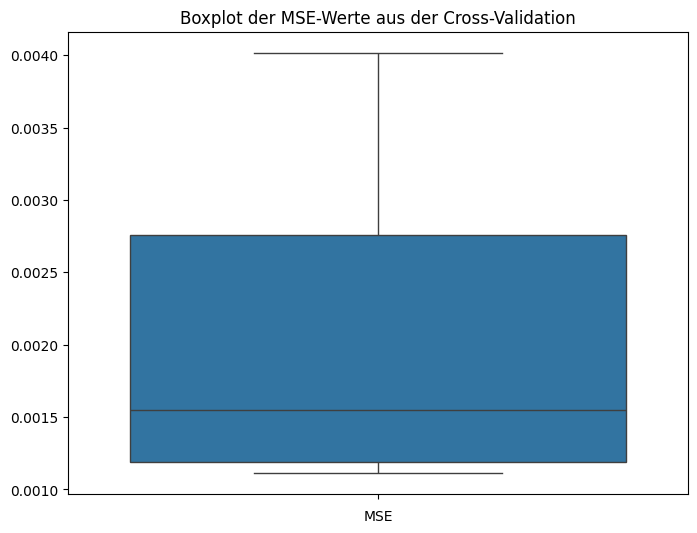

In [27]:

# MSE-Werte aus der Cross-Validation
mse_scores = [0.00275615, 0.00118871, 0.00111586, 0.00401681, 0.00155202]

plt.figure(figsize=(8, 6))
sns.boxplot(mse_scores)
plt.title('Boxplot der MSE-Werte aus der Cross-Validation')
plt.xlabel('MSE')
plt.show()

#### Histogramm der MSE-Werte aus der CV:

Ein Histogramm zeigt die Häufigkeitsverteilung der MSE-Werte. Dies ist nützlich, um zu sehen, ob die Fehler gleichmäßig verteilt sind oder ob es eine Häufung in einem bestimmten Bereich gibt.

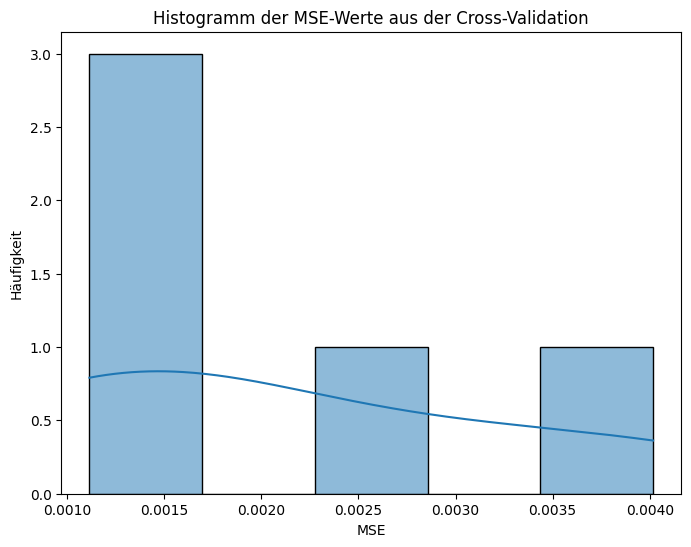

In [28]:


plt.figure(figsize=(8, 6))
sns.histplot(mse_scores, bins=5, kde=True)
plt.title('Histogramm der MSE-Werte aus der Cross-Validation')
plt.xlabel('MSE')
plt.ylabel('Häufigkeit')
plt.show()

#### Barplot der MSE-Werte aus der Crossvalidation:

Ein Barplot zeigt die MSE-Werte für jeden Fold separat. Dies kann nützlich sein, um die Performance in jedem Fold direkt zu vergleichen.

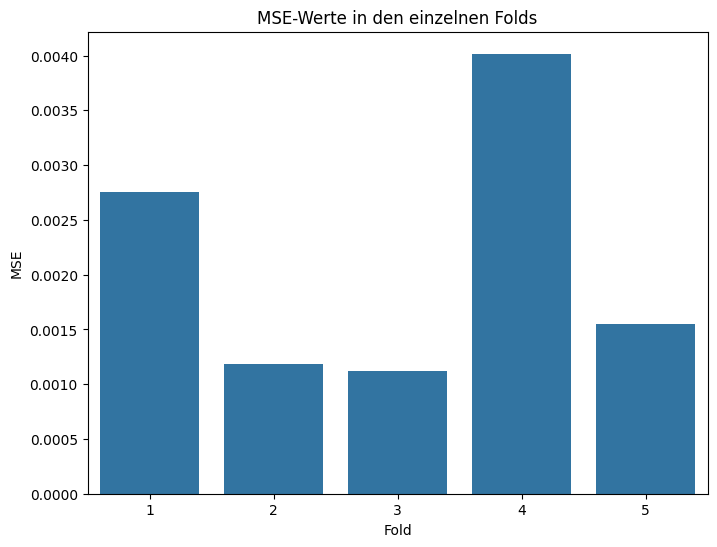

In [29]:
plt.figure(figsize=(8, 6))
sns.barplot(x=list(range(1, len(mse_scores) + 1)), y=mse_scores)
plt.title('MSE-Werte in den einzelnen Folds')
plt.xlabel('Fold')
plt.ylabel('MSE')
plt.show()

### Visualisierung der Vorhersagegenauigkeit (Paritätsplot)

**Ein Paritätsplot** stellt die tatsächlichen Werte gegen die vorhergesagten Werte dar. Eine *perfekte Vorhersage würde alle Punkte auf einer 45°-Linie liegen* lassen. Abweichungen von dieser Linie zeigen Fehler im Modell.

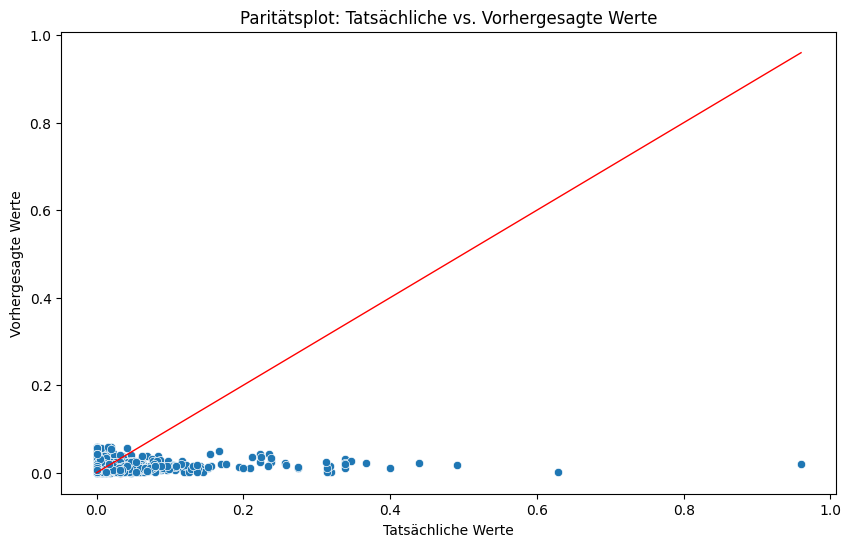

In [30]:
# Paritätsplot erstellen
plt.figure(figsize=(10,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=1)
plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('Paritätsplot: Tatsächliche vs. Vorhergesagte Werte')
plt.show()


#### Anpassung der Skalen

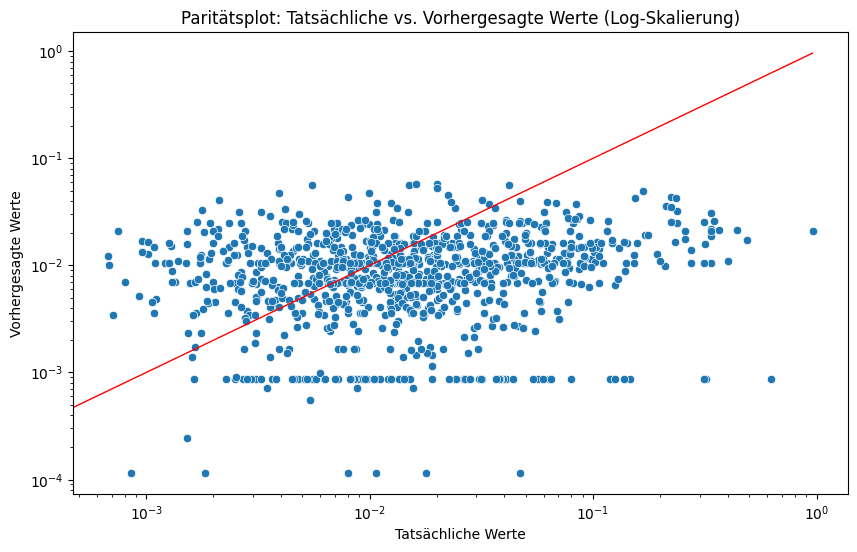

In [31]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_test, y=y_pred)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', lw=1)

# Logarithmische Skalierung der Achsen
plt.xscale('log')
plt.yscale('log')

plt.xlabel('Tatsächliche Werte')
plt.ylabel('Vorhergesagte Werte')
plt.title('Paritätsplot: Tatsächliche vs. Vorhergesagte Werte (Log-Skalierung)')
plt.show()


### Visualisierung der Hyperparameter:

Visualisierung der Leistung des Modells in Abhängigkeit von den gewählten Hyperparametern 

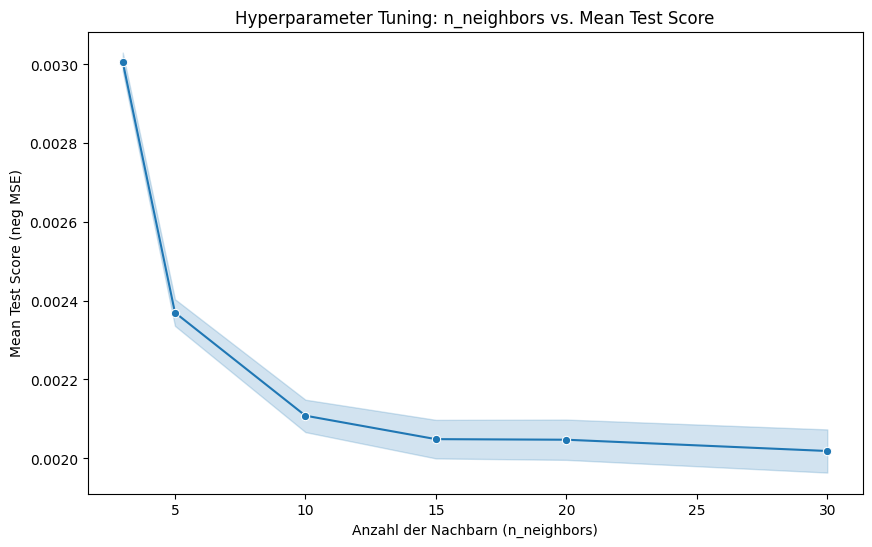

In [32]:
# Ergebnisse des GridSearchCV extrahieren
results = grid_search.cv_results_

# Plot für n_neighbors vs. Mean Test Score (neg MSE)
plt.figure(figsize=(10, 6))
sns.lineplot(x=results['param_knn__n_neighbors'], y=-results['mean_test_score'], marker='o')
plt.xlabel('Anzahl der Nachbarn (n_neighbors)')
plt.ylabel('Mean Test Score (neg MSE)')
plt.title('Hyperparameter Tuning: n_neighbors vs. Mean Test Score')
plt.show()

### Visualisierung der Vorhersageverteilung:

Eine Histogramm- oder Dichteplot-Darstellung der tatsächlichen und vorhergesagten Werte kann zeigen, wie gut das Modell die Verteilung der Zielvariablen erfasst.

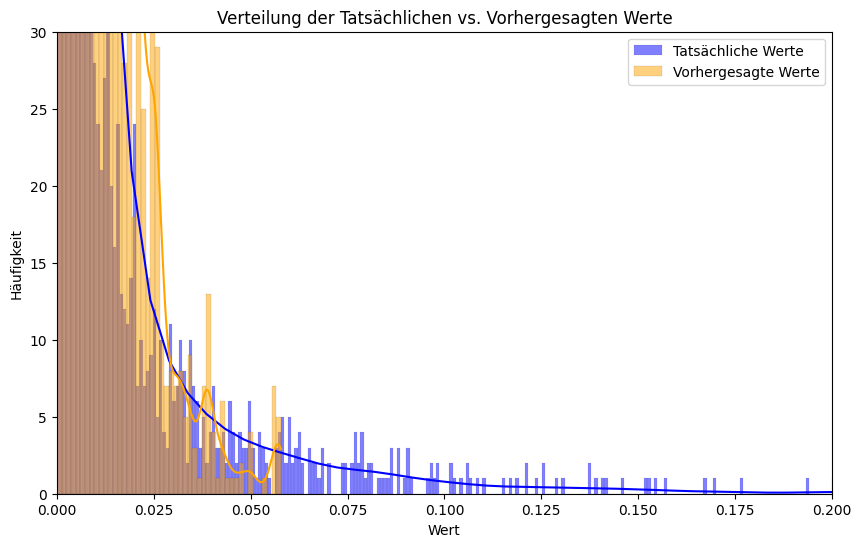

In [33]:
# Histogramm der tatsächlichen vs. vorhergesagten Werte
plt.figure(figsize=(10, 6))
sns.histplot(y_test, kde=True, color='blue', label='Tatsächliche Werte')
sns.histplot(y_pred, kde=True, color='orange', label='Vorhergesagte Werte')
plt.xlabel('Wert')
plt.ylabel('Häufigkeit')
plt.title('Verteilung der Tatsächlichen vs. Vorhergesagten Werte')

# Achsenlimits setzen, zur besseren Visualisierung
plt.xlim(0, 0.2)  
plt.ylim(0, 30)  

plt.legend()
plt.show()